# SNA Project - Network Comparison Between In-Person Meetings and Phone Calls in Criminal Associations

### Library imports and network loading

In [1]:
import networkx as nx   # Key library for network analysis
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load datasets
meetings_file = r'Dataset\Cleaned\Montagna_Meetings_Clean.csv'
df_meetings = pd.read_csv(meetings_file, sep=',', header=None, names=['Source', 'Target', 'Weight'])
calls_file = r'Dataset\Cleaned\Montagna_Phone_Calls_Clean.csv'
df_calls = pd.read_csv(calls_file, sep=',', header=None, names=['Source', 'Target', 'Weight'])

In [4]:
# Clean the data from repeated edges and self-loops from meetings dataset

# Ensure undirected edge ordering (we sort from smallest node id to largest)
df_meetings['Source_clean'] = df_meetings[['Source', 'Target']].min(axis=1) 
df_meetings['Target_clean'] = df_meetings[['Source', 'Target']].max(axis=1)
# Aggregate weights by grouping edges (sum)
df_meetings_agg = df_meetings.groupby(['Source_clean', 'Target_clean'], as_index=False)['Weight'].sum() # Maybe average?
df_meetings_agg.rename(columns={'Source_clean': 'Source', 'Target_clean': 'Target'}, inplace=True)  # Rename columns to original names
# Remove self-loops (Source == Target)
df_meetings_agg = df_meetings_agg[df_meetings_agg['Source'] != df_meetings_agg['Target']]


# Clean the calls dataset similarly
df_calls['Source_clean'] = df_calls[['Source', 'Target']].min(axis=1)
df_calls['Target_clean'] = df_calls[['Source', 'Target']].max(axis=1)
df_calls_agg = df_calls.groupby(['Source_clean', 'Target_clean'], as_index=False)['Weight'].sum()   # Maybe average?
df_calls_agg.rename(columns={'Source_clean': 'Source', 'Target_clean': 'Target'}, inplace=True)
#f_calls_agg = df_calls_agg[df_calls_agg['Source'] != df_calls_agg['Target']]   # No self-loops in calls dataset

In [5]:
# Load networks from cleaned DataFrames
G_meetings = nx.Graph()
G_meetings.add_weighted_edges_from(df_meetings_agg.values)
G_calls = nx.Graph()
G_calls.add_weighted_edges_from(df_calls_agg.values)

In [6]:
# Print summary of the graphs
print(f"Meetings: {G_meetings.number_of_nodes()} nodes, {G_meetings.number_of_edges()} edges")
print(f"Calls: {G_calls.number_of_nodes()} nodes, {G_calls.number_of_edges()} edges")
print(f"Nodes in common: {len(set(G_meetings.nodes()) & set(G_calls.nodes()))}")

Meetings: 95 nodes, 248 edges
Calls: 94 nodes, 120 edges
Nodes in common: 46


In [ ]:
# # DEBUG - Identify self-loops
# def find_self_loops(G, name="Graph"):
#     loops = list(nx.selfloop_edges(G))
#     print(f"{name} - Number of self-loops: {len(loops)}")
#     if loops:
#         print("Self-loops found at nodes:", [u for u, _ in loops])

# find_self_loops(G_meetings, name="Meetings")
# find_self_loops(G_calls, name="Phone Calls")

# # Meetings - Number of self-loops: 1. Self-loops found at nodes: ['N47']

Meetings - Number of self-loops: 0
Phone Calls - Number of self-loops: 0


In [ ]:
# # DEBUG - Count duplicates
# duplicates = df_meetings_agg.duplicated(subset=['Source', 'Target'], keep=False)
# print(f"Duplicate edge rows in meetings: {duplicates.sum()}")

# duplicates_calls = df_calls_agg.duplicated(subset=['Source', 'Target'], keep=False)
# print(f"Duplicate edge rows in calls: {duplicates_calls.sum()}")

# # Duplicate edge rows in meetings: 6
# # Duplicate edge rows in calls: 4

Duplicate edge rows in meetings: 0
Duplicate edge rows in calls: 0


### Plot the separated networks

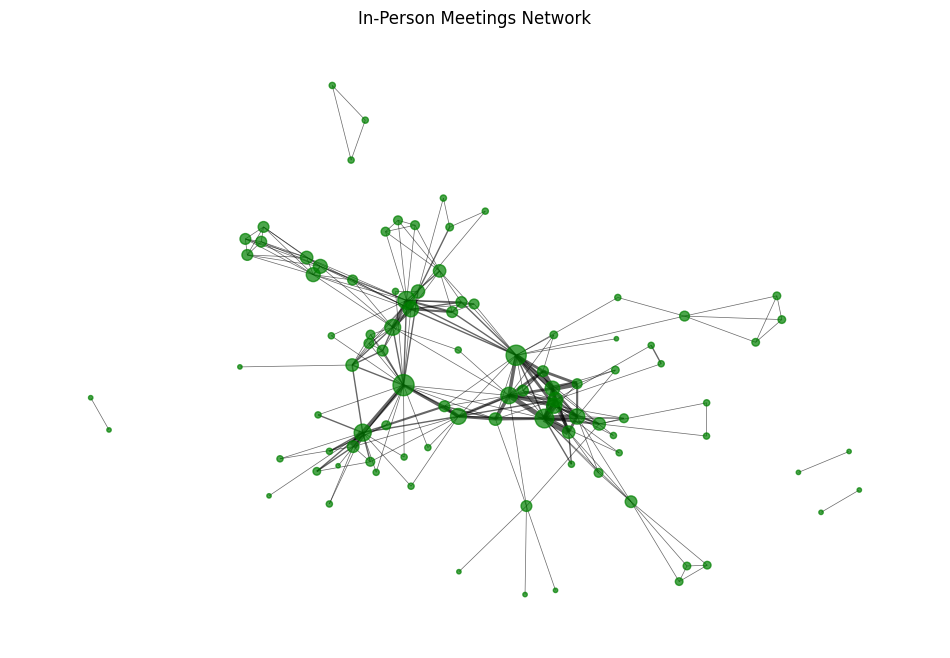

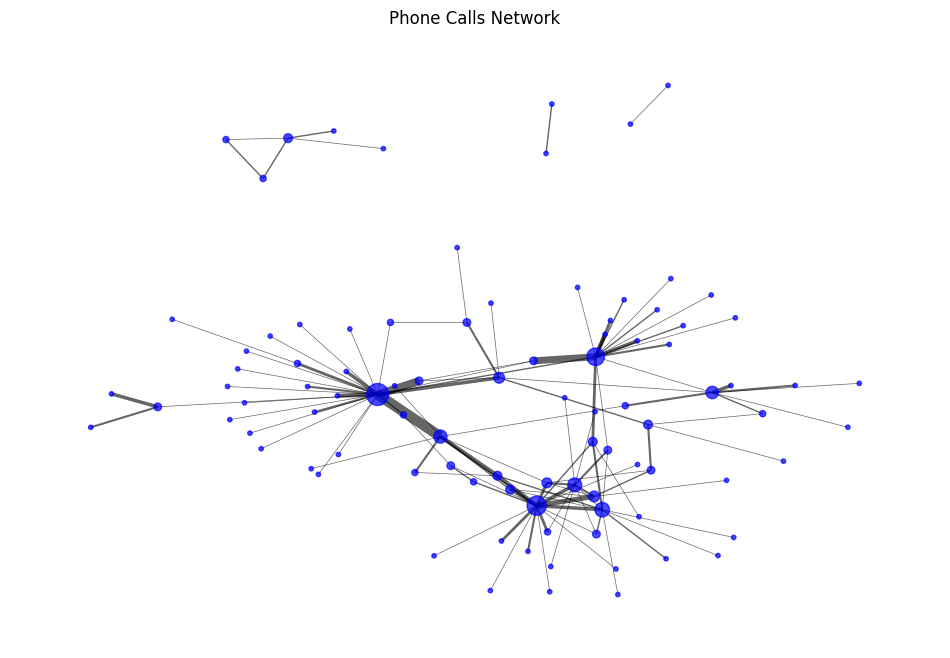

In [24]:
# Function to draw graphs. Scales node sizes by degree and edge widths by weight
def draw_graph(G, title, node_color='lightgray', edge_color='black'):
    plt.figure(figsize=(12, 8))  # Set figure size (change if a larger or smaller graph is needed)
    degrees = dict(G.degree())
    node_sizes = [degrees[n] * 10 for n in G.nodes()]  # Node size scaled by degree (scale factor = 10, can be adjusted)
    
    edge_weights = [G[u][v].get('weight', 1) * 0.5 for u, v in G.edges()]   # Edge width scaled by weight (scale factor = 0.5, can be adjusted)

    pos = nx.spring_layout(G, k=0.25, seed=42)  # Positions the nodes, using a certain layout ('spring'). k influences the distance between nodes

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes, alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_color, alpha=0.6)
    #nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title(title)
    plt.axis('off')
    plt.show()

draw_graph(G_meetings, "In-Person Meetings Network", node_color='green')
draw_graph(G_calls, "Phone Calls Network", node_color='blue')

### Combined Graph

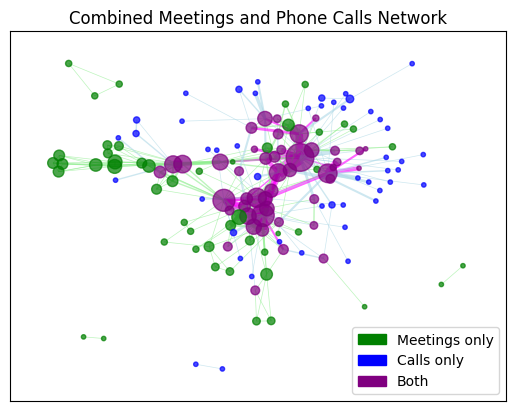

In [ ]:
# Combine the two graphs
G_combined = nx.Graph()
# G_combined.add_edges_from(G_meetings.edges(data=True))  # data=True carries edge attributes (weights)
# G_combined.add_edges_from(G_calls.edges(data=True))     # Adds edges that are not already in the graph. Nodes in common are merged.

# Add meetings edges
for u, v, data in G_meetings.edges(data=True):
    w = data.get('weight', 1)
    if G_combined.has_edge(u, v):
        # If edge already exists, add the weight
        G_combined[u][v]['weight'] += w
        G_combined[u][v]['methods'].add('meetings')
    else:
        G_combined.add_edge(u, v, weight=w, methods={'meetings'})
# Add calls edges similarly
for u, v, data in G_calls.edges(data=True):
    w = data.get('weight', 1)
    if G_combined.has_edge(u, v):
        G_combined[u][v]['weight'] += w
        G_combined[u][v]['methods'].add('calls')
    else:
        G_combined.add_edge(u, v, weight=w, methods={'calls'})

# Classify edges
edge_colors = []
for u, v in G_combined.edges():
    methods = G_combined[u][v]['methods']
    if methods == {'meetings'}:
        edge_colors.append('lightgreen')  # Meetings only
    elif methods == {'calls'}:
        edge_colors.append('lightblue')   # Calls only
    else:
        edge_colors.append('magenta') # Both

# Classify nodes
nodes_meetings = set(G_meetings.nodes())
nodes_calls = set(G_calls.nodes())

node_colors = {}
for node in G_combined.nodes():
    in_meetings = node in nodes_meetings
    in_calls = node in nodes_calls
    if in_meetings and in_calls:
        node_colors[node] = 'purple'  # both
    elif in_meetings:
        node_colors[node] = 'green'   # only meetings
    elif in_calls:
        node_colors[node] = 'blue'    # only calls
colors_list = [node_colors[n] for n in G_combined.nodes()]  

# Node sizes (scaled by degree)
degrees = dict(G_combined.degree())
node_sizes = [degrees[n] * 10 for n in G_combined.nodes()]
edge_weights = [G_combined[u][v]['weight'] * 0.5 for u, v in G_combined.edges()]    # Edge thickness (scaled by weight, factor = 0.5)

pos = nx.spring_layout(G_combined, k=0.25, seed=42) # Positions the nodes, using a certain layout ('spring'). k influences the distance between nodes

plt.figure(figsize=(12, 8))  # Set figure size (change if a larger or smaller graph is needed)
# Draw combined graph
nx.draw_networkx_nodes(G_combined, pos, node_color=colors_list, node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(G_combined, pos, width=edge_weights, edge_color=edge_colors, alpha=0.6)
#nx.draw_networkx_labels(G_combined, pos, font_size=8)

# Add legend
import matplotlib.patches as mpatches
legend = [mpatches.Patch(color='green', label='Meetings only'),
          mpatches.Patch(color='blue', label='Calls only'),
          mpatches.Patch(color='purple', label='Both')]
plt.legend(handles=legend)
plt.title("Combined Meetings and Phone Calls Network")
plt.show()

### Graph analysis

In [28]:
# Find the nodes in common between the two graphs
nodes_meetings = set(G_meetings.nodes())
nodes_calls = set(G_calls.nodes())
common_nodes = nodes_meetings & nodes_calls # Intersection

print(f"Nodes in common between Meetings and Phone Calls networks: {len(common_nodes)}")
print("Common nodes:", sorted(common_nodes))

Nodes in common between Meetings and Phone Calls networks: 46
Common nodes: [11, 12, 14, 18, 19, 21, 22, 23, 25, 27, 29, 31, 32, 33, 34, 36, 40, 43, 45, 47, 48, 49, 50, 51, 52, 54, 56, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 75, 77, 80, 95, 96, 97, 98, 99, 100]


In [29]:
# Function to print graph statistics. Statistics include:
# - Number of nodes, edges, and connected components
# - Max and average edge weight
# - Max and average node degree
# - Max shortest path length ("diameter") - Note: computes the diameter of the largest connected component
def print_graph_stats(G, name="Graph"):
    print(f"--- {name} ---")
    
    # Basic info (number of nodes, edges and components)
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    num_components = nx.number_connected_components(G)
    print(f"Nodes: {num_nodes}")
    print(f"Edges: {num_edges}")
    print(f"Connected components: {num_components}")
    
    # Edge weights
    edge_weights = [G[u][v].get('weight', 1) for u, v in G.edges()]
    max_weight = max(edge_weights)
    avg_weight = np.mean(edge_weights)
    print(f"Max edge weight: {max_weight}")
    print(f"Average edge weight: {avg_weight:.2f}")

    # Node degrees
    degrees = dict(G.degree())
    max_degree = max(degrees.values())
    avg_degree = np.mean(list(degrees.values()))
    print(f"Max node degree: {max_degree}")
    print(f"Average node degree: {avg_degree:.2f}")

    # Shortest path stats
    if nx.is_connected(G):  # Our graphs are disconnected, so this piece is always skipped
        diameter = nx.diameter(G)
    else:                   # Work on the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(largest_cc)
        diameter = nx.diameter(G_sub)
    print(f"Max shortest path length (diameter): {diameter}")
    
    print()  # Blank line for readability

In [35]:
print_graph_stats(G_meetings, name="Meetings Network")
print_graph_stats(G_calls, name="Phone Calls Network")

--- Meetings Network ---
Nodes: 95
Edges: 248
Connected components: 5
Max edge weight: 11
Average edge weight: 1.83
Max node degree: 23
Average node degree: 5.22
Max shortest path length (diameter): 6

--- Phone Calls Network ---
Nodes: 94
Edges: 120
Connected components: 4
Max edge weight: 15
Average edge weight: 2.30
Max node degree: 25
Average node degree: 2.55
Max shortest path length (diameter): 7



In [38]:
print_graph_stats(G_combined, name="Combined Network")  # Note: there are 47 nodes *in common* between the two networks

--- Combined Network ---
Nodes: 143
Edges: 326
Connected components: 5
Max edge weight: 19
Average edge weight: 2.24
Max node degree: 40
Average node degree: 4.56
Max shortest path length (diameter): 6



### Further analysis

In [ ]:
# Idk forse fare i vari tipi di centrality, la più adatta dovrebbe essere la betweenness centrality